# **Importaciónes generales**
**Importamos paquetes necesarios y los datos de Fashion MNIST, tambien se definen algunas funciones basicas del plot de imágenes y la de rounded accuracy para las metrics**

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd


# Seed para que las redes con iguales parametros no generen resultados aleatorios y siempre sean iguales
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


2024-03-26 20:33:00.928922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 20:33:00.929051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 20:33:01.110959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Sección 2.2**

2.2.1 Autoencoder regularizado usando convolucionales

**Definición y entrenamiento**

In [14]:
#Clear session para evitar que se guarde el entrenamiento por cada corrida del codigo, y volver a marcar la seed para evitar el factor aleatorio
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
#Early stop por si es necesario
#Early_stop=keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.0001,patience=3,verbose=1,restore_best_weights=True,start_from_epoch=150)

#Definicion del encoder con convolucionales 
conv_encoder = keras.models.Sequential([
    keras.layers.Input(shape=[28, 28]),
    keras.layers.Reshape([28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2)
])
#Definición del decoder con convolucionales
conv_decoder = keras.models.Sequential([
    keras.layers.Input(shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

#Definicion del autoencoder combinando el enconder y decoder ya definidos
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

#Se compila y entrena el modelo
conv_ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, 128,epochs=300,
                      validation_data=(X_valid, X_valid))#,callbacks=[Early_stop])


Epoch 1/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - loss: 3.7142 - rounded_accuracy: 0.5895 - val_loss: 2.2077 - val_rounded_accuracy: 0.7438
Epoch 2/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8855 - rounded_accuracy: 0.8443 - val_loss: 1.1687 - val_rounded_accuracy: 0.7846
Epoch 3/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0019 - rounded_accuracy: 0.8820 - val_loss: 0.6623 - val_rounded_accuracy: 0.7825
Epoch 4/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5662 - rounded_accuracy: 0.8979 - val_loss: 0.4069 - val_rounded_accuracy: 0.7843
Epoch 5/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3478 - rounded_accuracy: 0.9074 - val_loss: 0.2781 - val_rounded_accuracy: 0.7878
Epoch 6/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2365 - rounded_accuracy: 0.9182 - val_loss: 0.2126 - val_rounded_accuracy: 0.7953
Epoch 7/300
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1774 - rounded_accuracy: 0.9261 - val_loss: 0.1706 - val_rounded_

**Evolución del loss y accuracy**

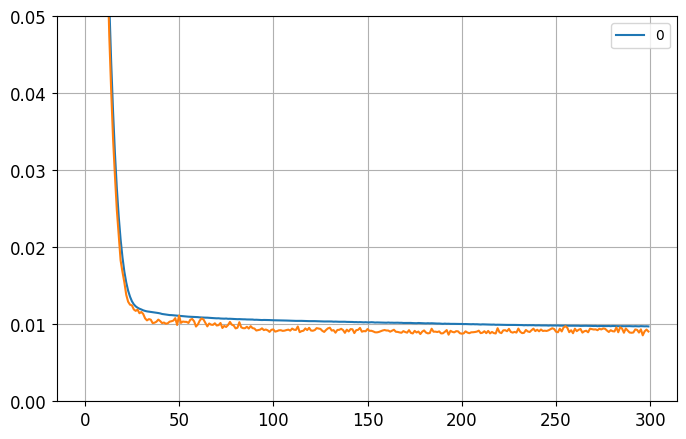

In [15]:
#Graficamos el loss de entrenamiento y de validación

pd.DataFrame(history.history["loss"]).plot(figsize=(8, 5))
plt.plot(history.history["val_loss"])
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0,0.05)
plt.show()

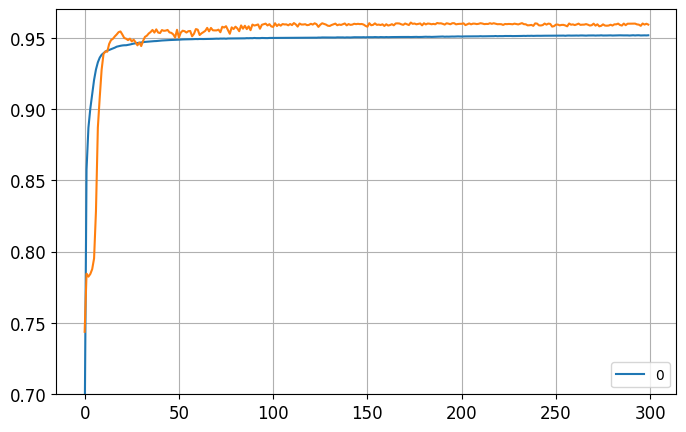

In [16]:
#Graficamos el accuracy de entrenamiento y el de validación

pd.DataFrame(history.history["rounded_accuracy"]).plot(figsize=(8, 5))
plt.plot(history.history["val_rounded_accuracy"])
plt.grid(True)
#plt.xlim(0,20)
plt.ylim(0.7,0.97)
plt.show()

**Predicción y Visualización de resultados**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


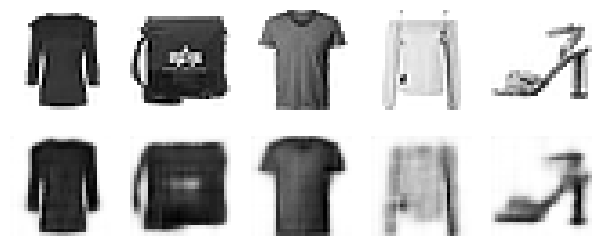

In [17]:
#Usando la función definida se hace una predicción y se visualiza

show_reconstructions(conv_ae)
plt.show()

**Discusión**

* Los valores y convergencia del loss y accuracy son bastante satisfactorios, lo que se puede observar bien en las imagenes de la reconstrucción comparadas con las originales.

* Las gráficas de evolución del loss y accuracy muestran pocas fluctuaciones y una buena tendencia a la convergencia, lo que me lleva a resaltar una buena elección del optimizador y el learning rate.

* Tambíen probé con el pooling, cambiando de maxpooling a averagepooling, pero el resultado fue mejor en maxpooling, asi que en este caso favorece más el valor máximo que el promedio.

* Parámetros como el stride o el kernel size tambien pueden modificarse pero son más limitados por el tamaño requerido de las imagenes en el output, trate de modificarlo pero el mejor resultado fue siempre con kernel=3 y stride=2, cambiarlos dejando el mismo tamaño de output solo empeora el resultado de salida.

* Respecto a los tips de entrenamiento se pueden resaltar varias cosas:

    1. Si ubiera seguido con el optimizador SGD se podian ver resultados aceptables casi sin emplear ningún tip, y tampoco daba señales de overfitting, pero al cambiar a Adam los resultados sin emplear tips de entrenamiento eran muy malos, y SGD requeria un learning rate muy alto para converger a un resultado aceptable en menos de 300 epocas, tardando demasiado en la ejecución.
    2. Utilizando inicializadores y batch normalization Adam ya llegaba a algo, aunque seguia lejos de ser bueno, al menos se podía ver algun resultado de la predición, con mucho loss y poco accuracy.
    3. Ajustando el learning rate a un número inferior a 0.01, y utilizando regularizadores y dropout, pude darle 300 epocas a Adam para lograr el resultado final sin riesgo de overfitting. Lo más importante de esto fue el learning rate, con SGD un learning rate de 0.001 necesitaria unas 500 epocas para llegar al resultado que alcanzo Adam, pero sin los regularizadores ni el dropout el resulado no era bueno y corría riesgo de overfitting.
 
* Al final, con un loss de menos de 0.009 y un accuracy de más de 0.95, quedo conforme con el resultado del entrenamiento de la red.


2.2.3 GANs

**Difinición y Entrenamiento**